# Part 2: Image Mosaics
In this part of the assignment, you will implement an image stitcher that uses image warping
and homographies to automatically create an image mosaic. We will focus on the case where
we have two input images that should form the mosaic, where we warp one image into the plane
of the second image and display the combined views. original input.


## **Imports**

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
from matplotlib import pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## **Displaying 2 Images to be stitched**

In [ ]:
img1 = cv2.imread('/content/drive/MyDrive/image1.jpg')
img2 = cv2.imread('/content/drive/MyDrive/image2.jpg')

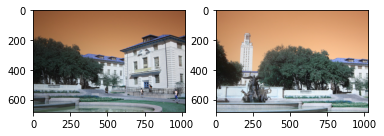

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(img1)
axarr[1].imshow(img2)

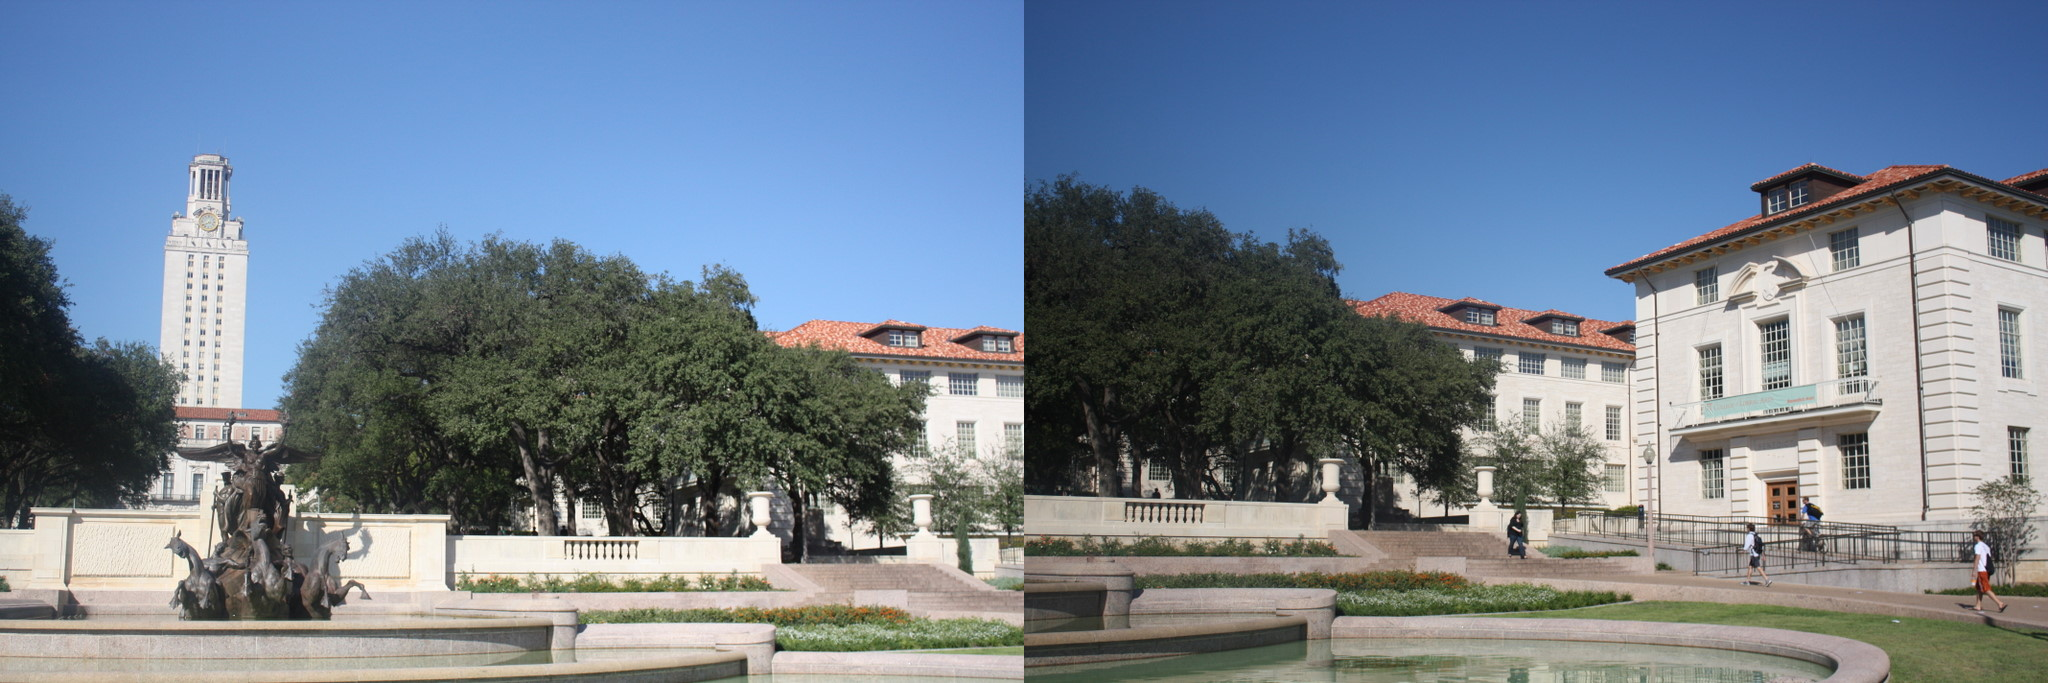

In [ ]:
# concatenate image Horizontally
Hori = np.concatenate((img2, img1), axis=1)
 
# concatenate image Vertically
# Verti = np.concatenate((img1, img2), axis=0)
 
cv2_imshow(Hori)
# cv2_imshow(Verti)

# *2.1 Getting Correspondences and Compute the Homography Parameters*

## **1.1 Get correspondences**

The first step is to find the correspondences between the 2 images.
Use SIFT descriptor from opencv library to find keypoints in each image and then use the brute force matcher from opencv to get the correspondences.
Use the matching way as KNN with size 2, and apply ratio checking between the best 2 matches to filter the good correspondences.
Choose 50 correspondences and plot them.

In [ ]:
def get_correspondences(img1,img2,k=50):
  sift = cv2.xfeatures2d.SIFT_create()
  keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None) # None ?
  keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
  #feature matching
  bf = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True) # params ?
  bf = cv2.BFMatcher()
  matches = bf.knnMatch(descriptors_1, descriptors_2, k=2)

  good = []
  for m,n in matches:
      if m.distance / n.distance  < 0.65:
          good.append([m.distance / n.distance,m])

  matches = sorted(good)[:k]
  good_matches = []
  for i in matches:
    good_matches.append(i[1])
    
  return keypoints_1,keypoints_2,good_matches

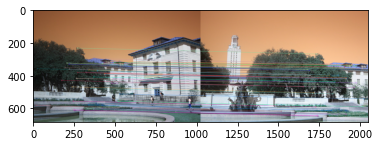

(<matplotlib.image.AxesImage at 0x7f85c4966a10>, None)

In [ ]:
keypoints_1, keypoints_2, matches = get_correspondences(img1, img2, 50)
matched_points = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches, img2, flags=2)
plt.imshow(matched_points),plt.show()

## **1.2 Compute the Homography Parameters**

In [ ]:
correspondenceList = []
points_1 = []
points_2 = []
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    points_1.append([x1,y1])
    points_2.append([x2,y2])
    correspondenceList.append([x1, y1, x2, y2])

In [ ]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    aList = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        aList.append(a1)
        aList.append(a2)

    matrixA = np.array(aList)

    #svd composition
    u, s, v = np.linalg.svd(matrixA)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    
    return h

In [ ]:
correspondenceList = np.array(correspondenceList)

In [ ]:
H = calculateHomography(correspondenceList)

In [ ]:
print(H)

[[ 7.64603188e-01  3.82708405e-02  4.47176487e+02]
 [-1.35859041e-01  9.12475432e-01  7.61632857e+01]
 [-2.10980785e-04 -3.16760125e-05  1.00000000e+00]]


In [ ]:
x = cv2.findHomography(np.array(points_1),np.array(points_2), )
print(x[0])

[[ 7.65473894e-01  3.91847455e-02  4.46973846e+02]
 [-1.35726004e-01  9.13724296e-01  7.58723001e+01]
 [-2.10533507e-04 -3.06297896e-05  1.00000000e+00]]


In [ ]:
def apply_homography(H,p):
  p = np.array([p[0],p[1],1])
  p_new = np.dot(H,p)
  x_new = round(p_new[0] / p_new[2])
  y_new = round(p_new[1] / p_new[2])
  return [x_new,y_new]

In [ ]:
def test_point(p,img1,img2,H):
  im1 = img1.copy()
  im2 = img2.copy()
  im1 = cv2.circle(im1,(p[0],p[1]), 5, (0,255,0), 4)
  p_new = apply_homography(H,p)
  im2 = cv2.circle(im2,(int(p_new[0]),int(p_new[1])), 5, (0,255,0), 4)
  fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(8,6))
  ax[0].imshow(im1)
  ax[1].imshow(im2)
  plt.imshow(im1)
  plt.imshow(im2)

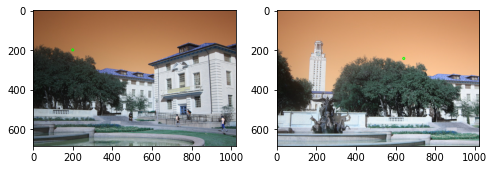

In [ ]:
test_point([200,200], img1, img2, H)

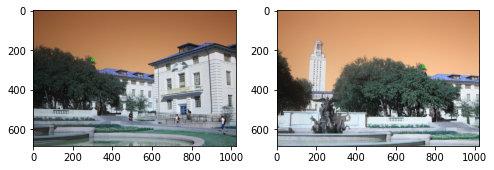

In [ ]:
test_point([300,250], img1, img2, H)

# *2.2 Warping Between Image Planes*

In [ ]:
def get_corners(img,H):
  Width,Length,_ = img.shape

  top_left = apply_homography(H,[0,0])
  top_right = apply_homography(H,[0,Width])
  bot_left = apply_homography(H,[Length,0])
  bot_right = apply_homography(H,[Length,Width])
  return top_left,top_right ,bot_left,bot_right

In [ ]:
tl,tr,bl,br = get_corners(img1,H)

In [ ]:
def display_corners(image,top_left,top_right,bot_left,bot_right):
  image = cv2.circle(image,(top_left[0],top_left[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(top_right[0],top_right[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(bot_left[0],bot_left[1]), 5, (0,255,0), 4)
  image = cv2.circle(image,(bot_right[0],bot_right[1]), 5, (0,255,0), 4)
  plt.imshow(image)

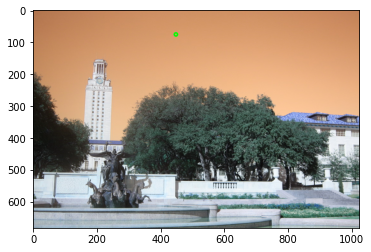

In [ ]:
img_copy = img2.copy()
display_corners(img_copy,tl,tr,bl,br)

In [ ]:
max_x = max(tl[0], max(tr[0], max(bl[0], br[0])))+1
max_y = max(tl[1], max(tr[1], max(bl[1], br[1])))+1
new_img = np.zeros((800, 1800, 3),  dtype = np.uint8)

In [ ]:
new_img.shape

(736, 1649, 3)

In [ ]:
Width,Length,_ = img1.shape
for i in range(Length):
  for j in range(Width):
    p_new = apply_homography(H,[i,j])
    new_img[p_new[1],p_new[0]] = img1[j][i]

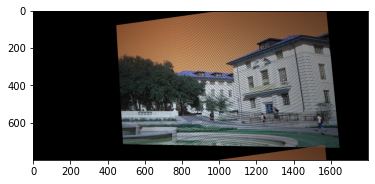

In [ ]:
plt.imshow(new_img)

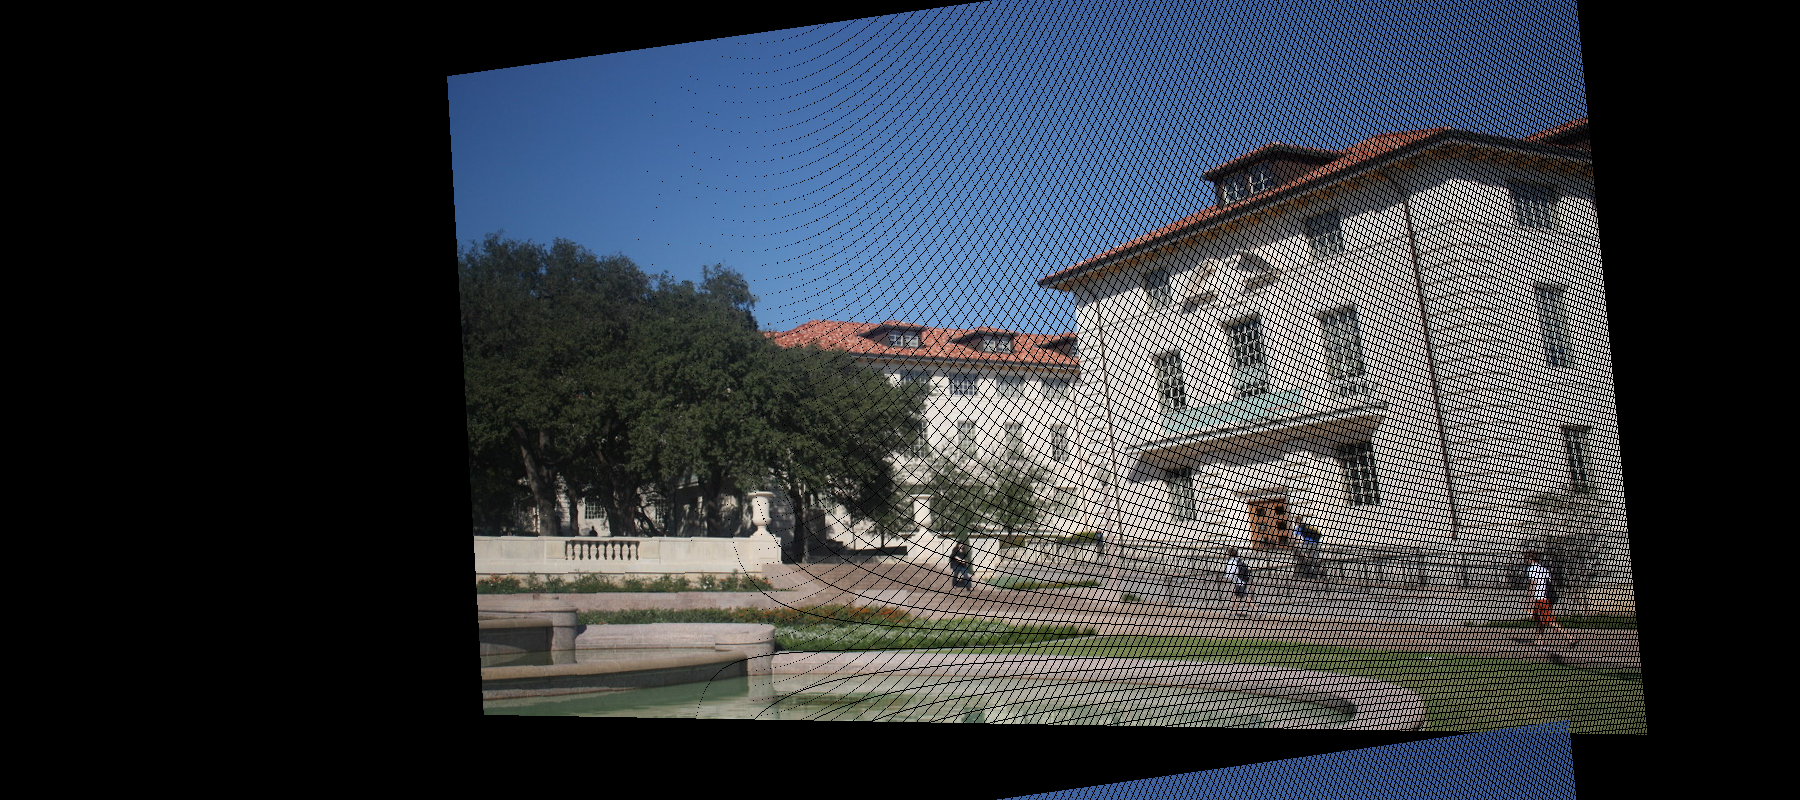

In [ ]:
cv2_imshow(new_img)

## **TRial**

In [ ]:
def transform(point,H):
  result = np.dot(H, point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result	

In [ ]:
def inv_transform(point,H):
  result = np.dot(np.linalg.inv(H), point)
  w=result[2]
  result[0] = result[0]/w
  result[1] = result[1]/w
  result[2] = 1
  return result

In [ ]:
def wraped_image_size(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  boundaries = np.array([[0,0],[height-1, 0],[0, width-1],[height-1, width-1]])
  i_s =np.zeros(4,dtype=int)
  j_s =np.zeros(4,dtype=int)
  
  for k in range(0,4):
    i = boundaries[k][0]
    j = boundaries[k][1]
    mapped = transform(np.array([[j],[i],[1]]), H)
    j_s[k] = int(mapped[0][0])
    i_s[k] = int(mapped[1][0])
          
  min_mapped_i=np.min(i_s)
  min_mapped_j=np.min(j_s)
  max_mapped_i=np.max(i_s)
  max_mapped_j=np.max(j_s)
   
  new_height = (max_mapped_i-min_mapped_i+1)
  new_width = (max_mapped_j-min_mapped_j+1)
  
  height_shift =-min_mapped_i
  width_shift =-min_mapped_j
  
  return (new_height,new_width,height_shift,width_shift)

In [ ]:
def wrap(image_a , H):
  height = image_a.shape[0]
  width = image_a.shape[1]

  (wraped_image_height,wraped_image_width,height_shift,width_shift)=wraped_image_size(image_a , H)
  wraped_image = np.zeros((wraped_image_height,wraped_image_width,3), dtype=np.uint8);
  
  for i in range(0,image_a.shape[0]):
    for j in range(0,image_a.shape[1]):
      mapped = transform(np.array([[j],[i],[1]]), H)
      mapped_j = int(mapped[0][0])
      mapped_i = int(mapped[1][0])
      wraped_image[mapped_i+height_shift][mapped_j+width_shift] = image_a[i][j]
      
  return (wraped_image,height_shift,width_shift)

In [ ]:
def remove_holes(wraped_image,H,image_a,height_shift,width_shift):
  height = image_a.shape[0]
  width = image_a.shape[1]
  
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]
  
  for i in range(0, wraped_image_height):
    for j in range(0, wraped_image_width):
      if int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][1]) == 0 and int(wraped_image[i][j][2]) == 0:
        inv_mapped = inv_transform(np.array([[(j - width_shift)], [(i-height_shift)],[1]]),H)
        inv_mapped_j = inv_mapped[0][0]
        inv_mapped_i = inv_mapped[1][0]
        if inv_mapped_i <= height-1 and  inv_mapped_i >= 0 and inv_mapped_j <= width-1 and inv_mapped_j >= 0:
          index_i = int(inv_mapped_i);
          index_j = int(inv_mapped_j);
          a = inv_mapped_i - index_i;
          b = inv_mapped_j - index_j;
          wraped_image[i][j] = (1-a)*(1-b)*image_a[index_i][index_j]+ a*(1-b)*image_a[index_i+1][index_j]+ a*b*image_a[index_i+1][index_j+1]+ (1-a)*b*image_a[index_i][index_j+1]  
  return wraped_image

In [ ]:
def create_mosaic(wraped_image,image_b,height_shift,width_shift):
  wraped_image_height=wraped_image.shape[0]
  wraped_image_width=wraped_image.shape[1]

  image_b_height = image_b.shape[0]
  image_b_width = image_b.shape[1]
  
  mosaic_height=0
  mosaic_width=0

  if wraped_image_height > image_b_height + height_shift :
    mosaic_height = wraped_image_height
  else:
    mosaic_height = image_b_height + height_shift

  if mosaic_width > image_b_width + width_shift:
    mosaic_width = mosaic_width
  else:
    mosaic_width = image_b_width + width_shift

  mosaic = np.zeros((2000, 2000, 3), dtype=np.uint8)
  
  for i in range(0,image_b_height):
    for j in range(0, image_b_width):
      mosaic[i+height_shift][j+width_shift] = image_b[i][j]
  
  for i in range(0,wraped_image_height):
    for j in range(0, wraped_image_width):
      if not(int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][0]) == 0 and int(wraped_image[i][j][2]) == 0):
        mosaic[i][j] = wraped_image[i][j]
        
  return mosaic     

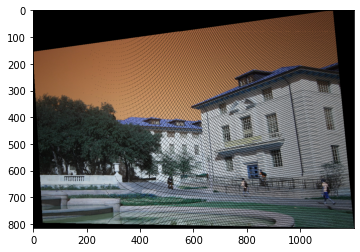

In [ ]:
(wraped_image,height_shift,width_shift) = wrap(img1,H)
plt.imshow(wraped_image)
# plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

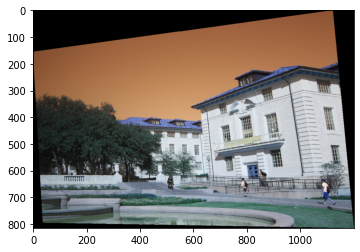

In [ ]:
wraped_image=remove_holes(wraped_image,H,img1,height_shift,width_shift)
plt.imshow(wraped_image)
# plot_image(BGR2RGB(wraped_image),'colored','wraped_image')

# *2.3 Create the output mosaic*

In [ ]:
def stitchImages(origImg, transformedImg, shiftX, shiftY, nChannels = 3):
  newImg = np.zeros(((origImg.shape[0] + transformedImg.shape[0]), (origImg.shape[1] + transformedImg.shape[1]), nChannels))
  newImg[0:transformedImg.shape[0],0:transformedImg.shape[1]] = transformedImg
  for row in range(origImg.shape[0]):
    for col in range(origImg.shape[1]):
      newX, newY = col + shiftX , row + shiftY
      newImg[newY][newX] = origImg[row][col]
  # # delete black rows & columns
  # idx = np.argwhere(np.all(newImg[..., :] == 0, axis=0))
  # newImg = np.delete(newImg, idx, axis=1)
  # idx = np.argwhere(np.all(newImg[..., :] == 0, axis=1))
  # newImg = np.delete(newImg, idx, axis=0)
  # rotate image columns if shift was -ve 
  if shiftX < 0:
    newImg = np.roll(newImg, -1* shiftX, axis=1)
  if shiftY < 0:
    newImg = np.roll(newImg, -1* shiftY, axis=0)
  return newImg.astype(np.uint8)

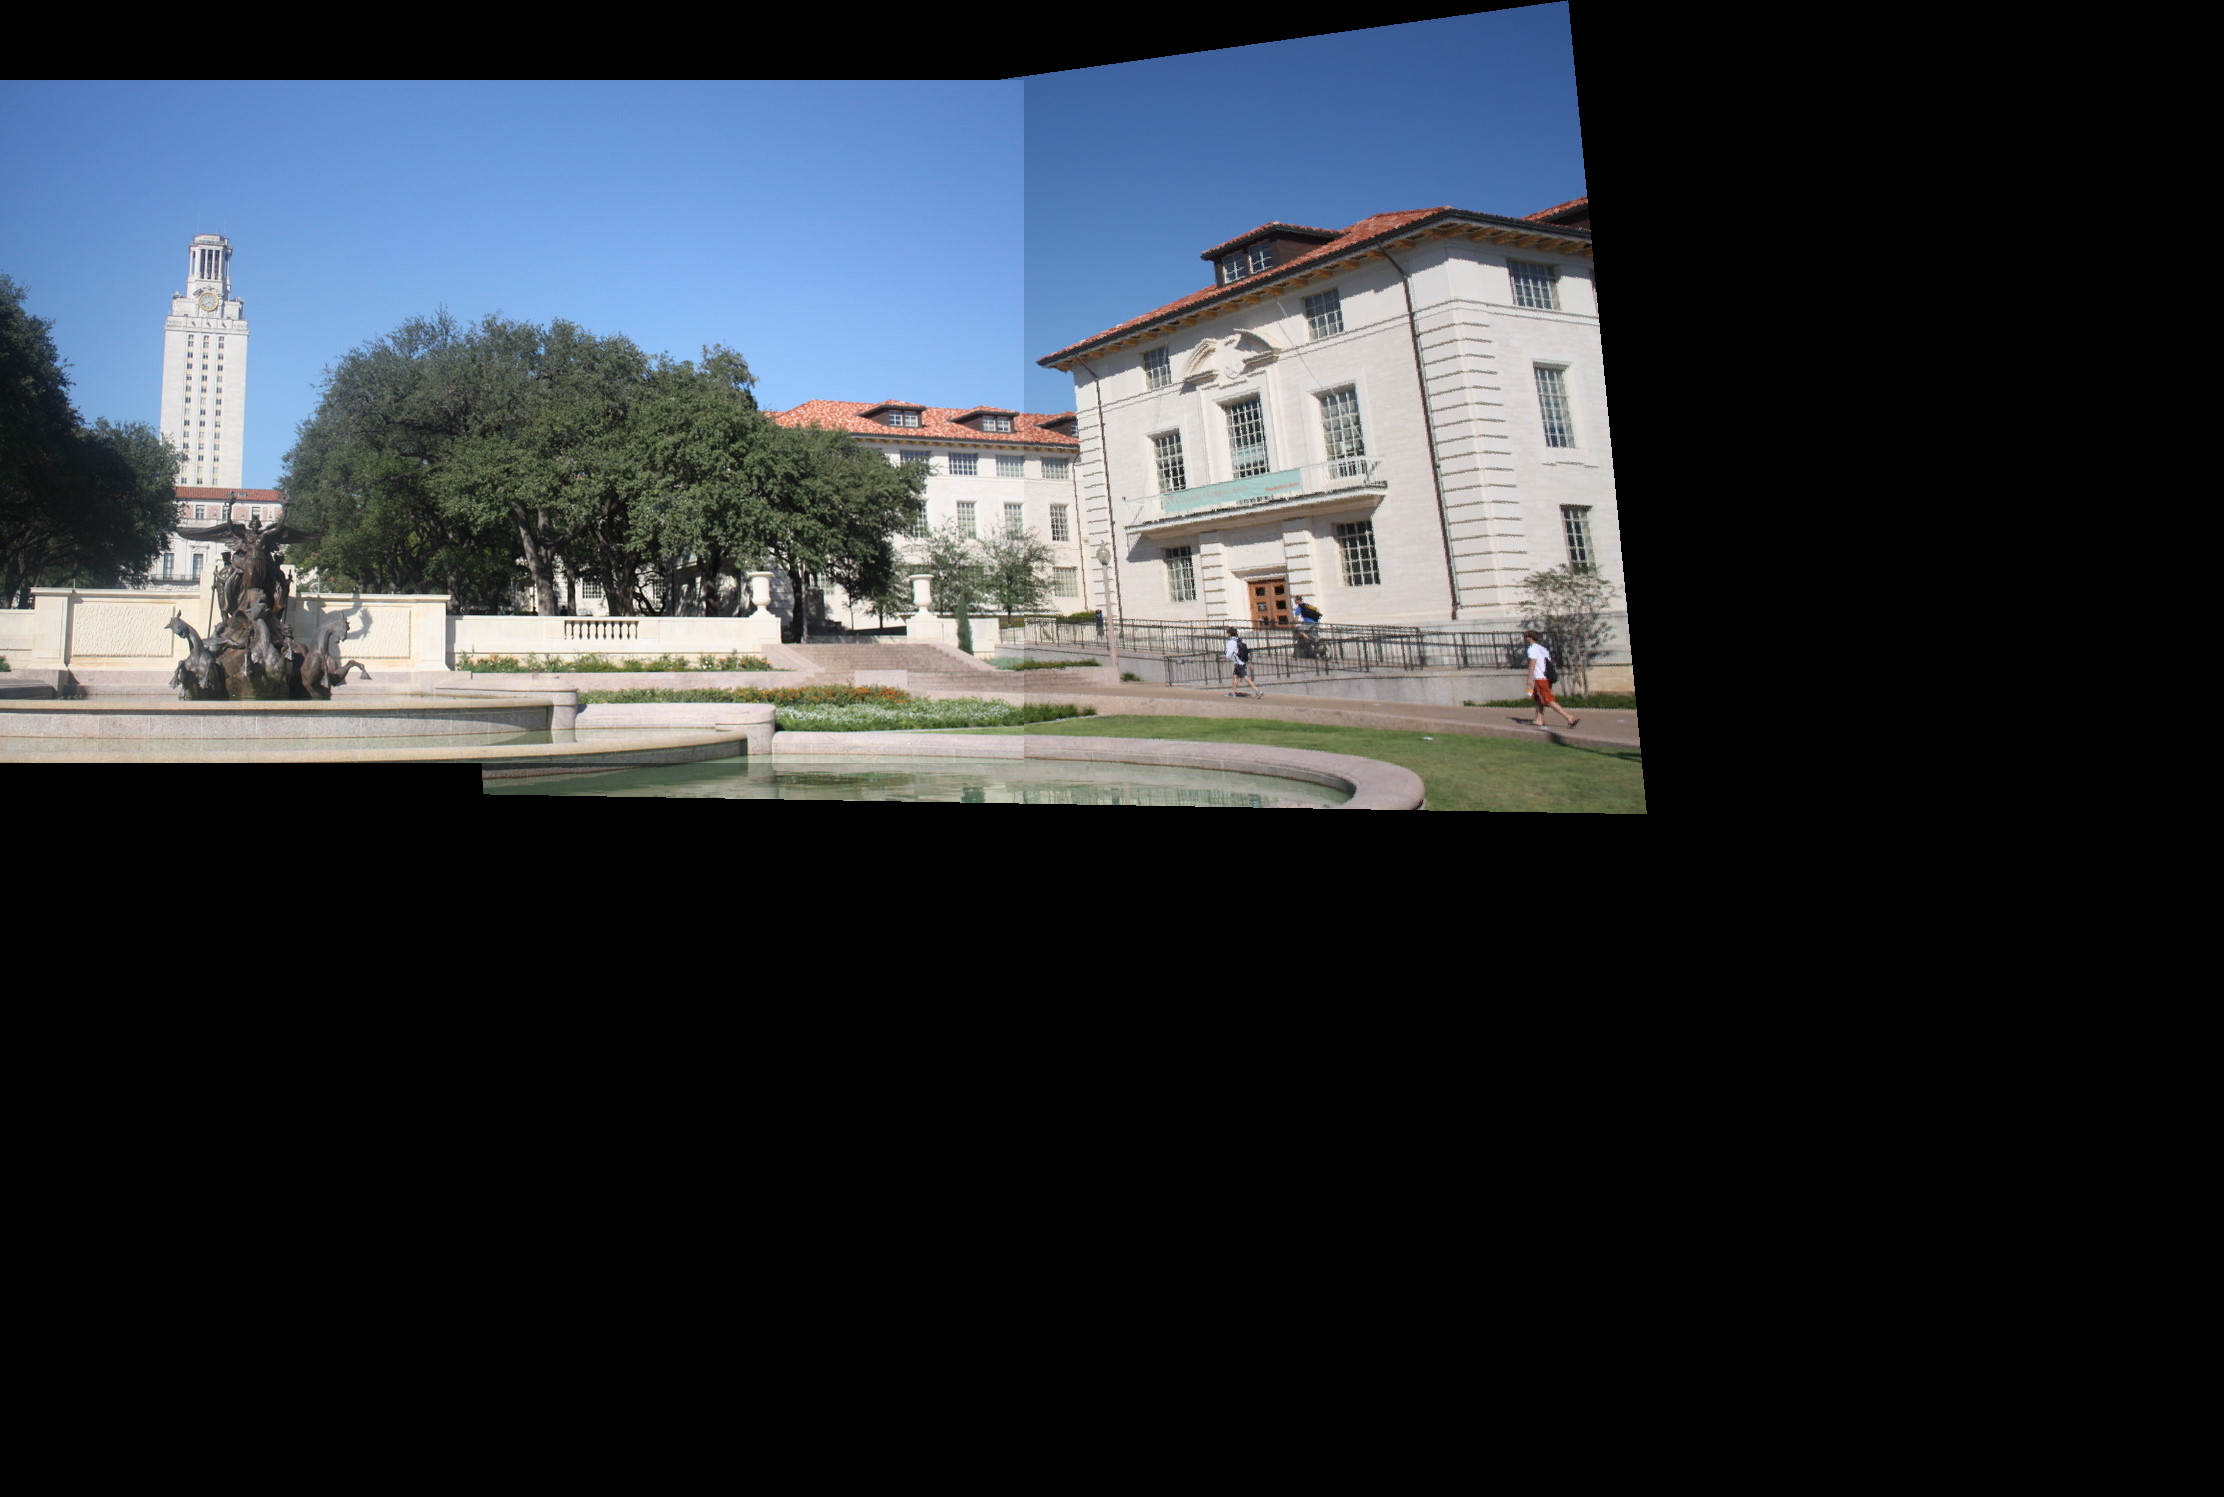

In [ ]:
outputImg = stitchImages(img2, wraped_image, width_shift, height_shift)
cv2_imshow(outputImg)

# *Bonus*

In [ ]:
im1 = cv2.imread('/content/shanghai-21.png')
im2 = cv2.imread('/content/shanghai-22.png')
im3 = cv2.imread('/content/shanghai-23.png')

In [ ]:
keypoints_1, keypoints_2, matches = get_correspondences(im1, im2, 50)

correspondenceList = []
points_1 = []
points_2 = []
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    points_1.append([x1,y1])
    points_2.append([x2,y2])
    correspondenceList.append([x1, y1, x2, y2])
correspondenceList = np.array(correspondenceList)
H_1 = calculateHomography(correspondenceList)

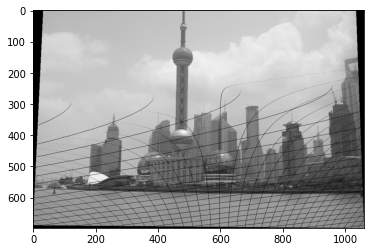

In [ ]:
(wraped_image,height_shift,width_shift) = wrap(im1,H_1)
plt.imshow(wraped_image)

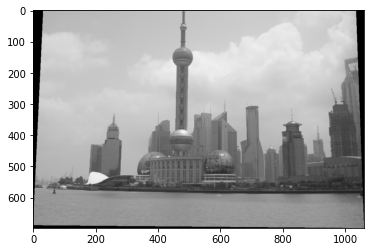

In [ ]:
wraped_image=remove_holes(wraped_image,H_1,im1,height_shift,width_shift)
plt.imshow(wraped_image)

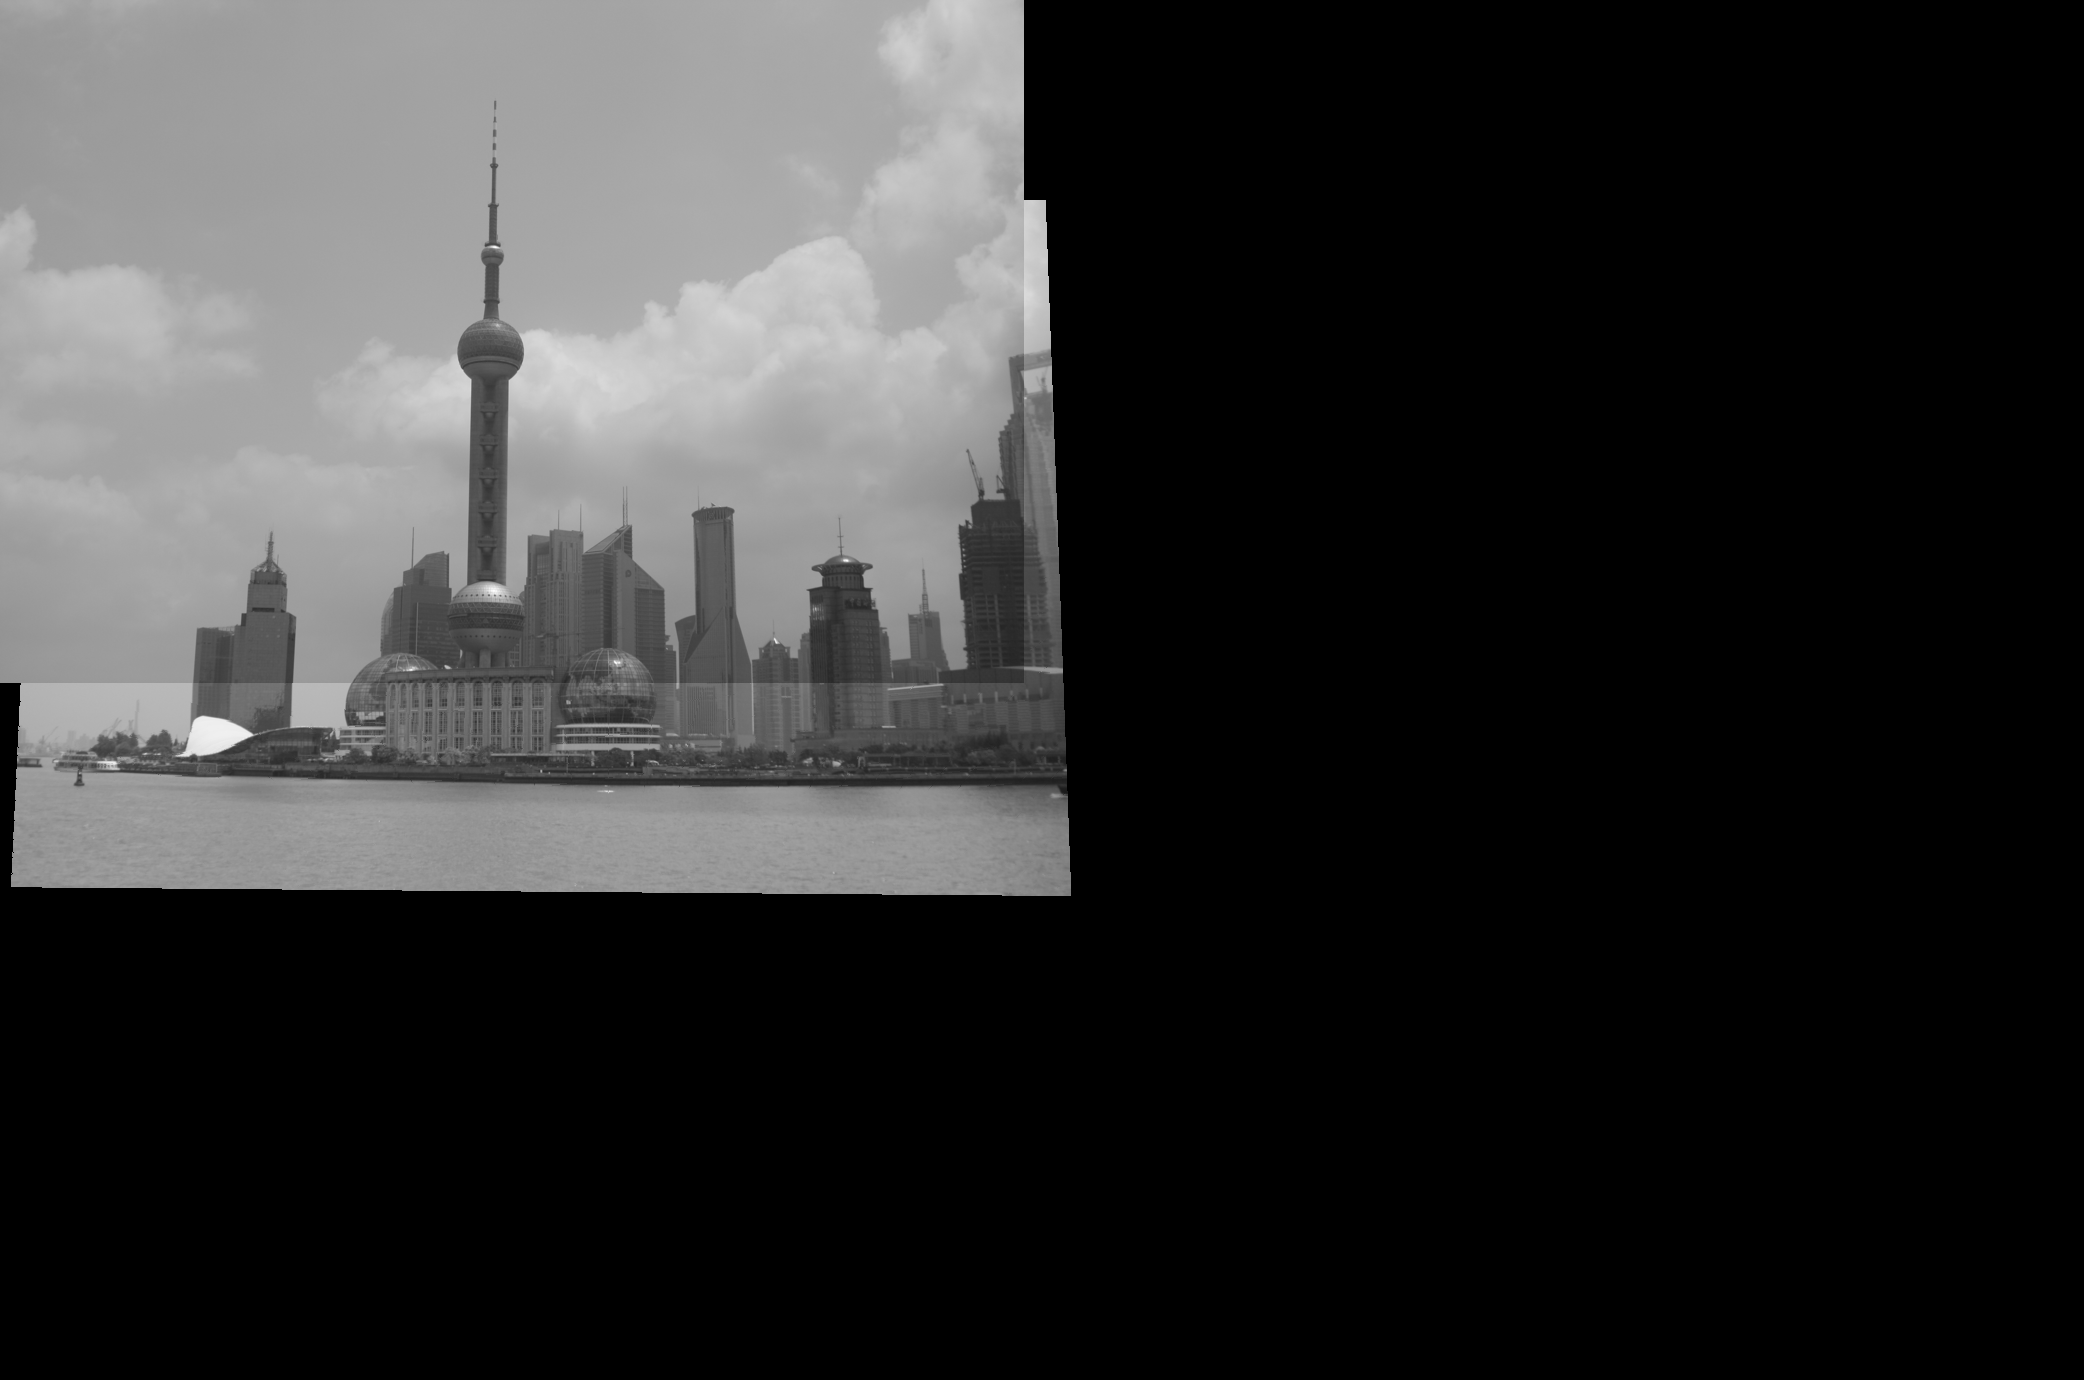

In [ ]:
outputImg = stitchImages(im2, wraped_image, width_shift, height_shift)
cv2_imshow(outputImg)

In [ ]:
keypoints_1, keypoints_2, matches = get_correspondences(outputImg, im3, 50)

correspondenceList = []
points_1 = []
points_2 = []
for match in matches:
    (x1, y1) = keypoints_1[match.queryIdx].pt
    (x2, y2) = keypoints_2[match.trainIdx].pt
    points_1.append([x1,y1])
    points_2.append([x2,y2])
    correspondenceList.append([x1, y1, x2, y2])
correspondenceList = np.array(correspondenceList)
H_2 = calculateHomography(correspondenceList)

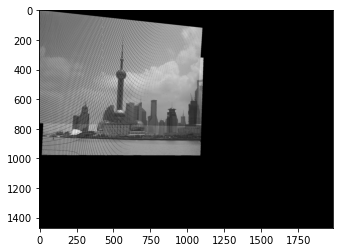

In [ ]:
(wraped_image,height_shift,width_shift) = wrap(outputImg,H_2)
plt.imshow(wraped_image)

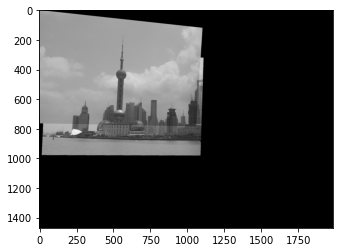

In [ ]:
wraped_image=remove_holes(wraped_image,H_2,outputImg,height_shift,width_shift)
plt.imshow(wraped_image)

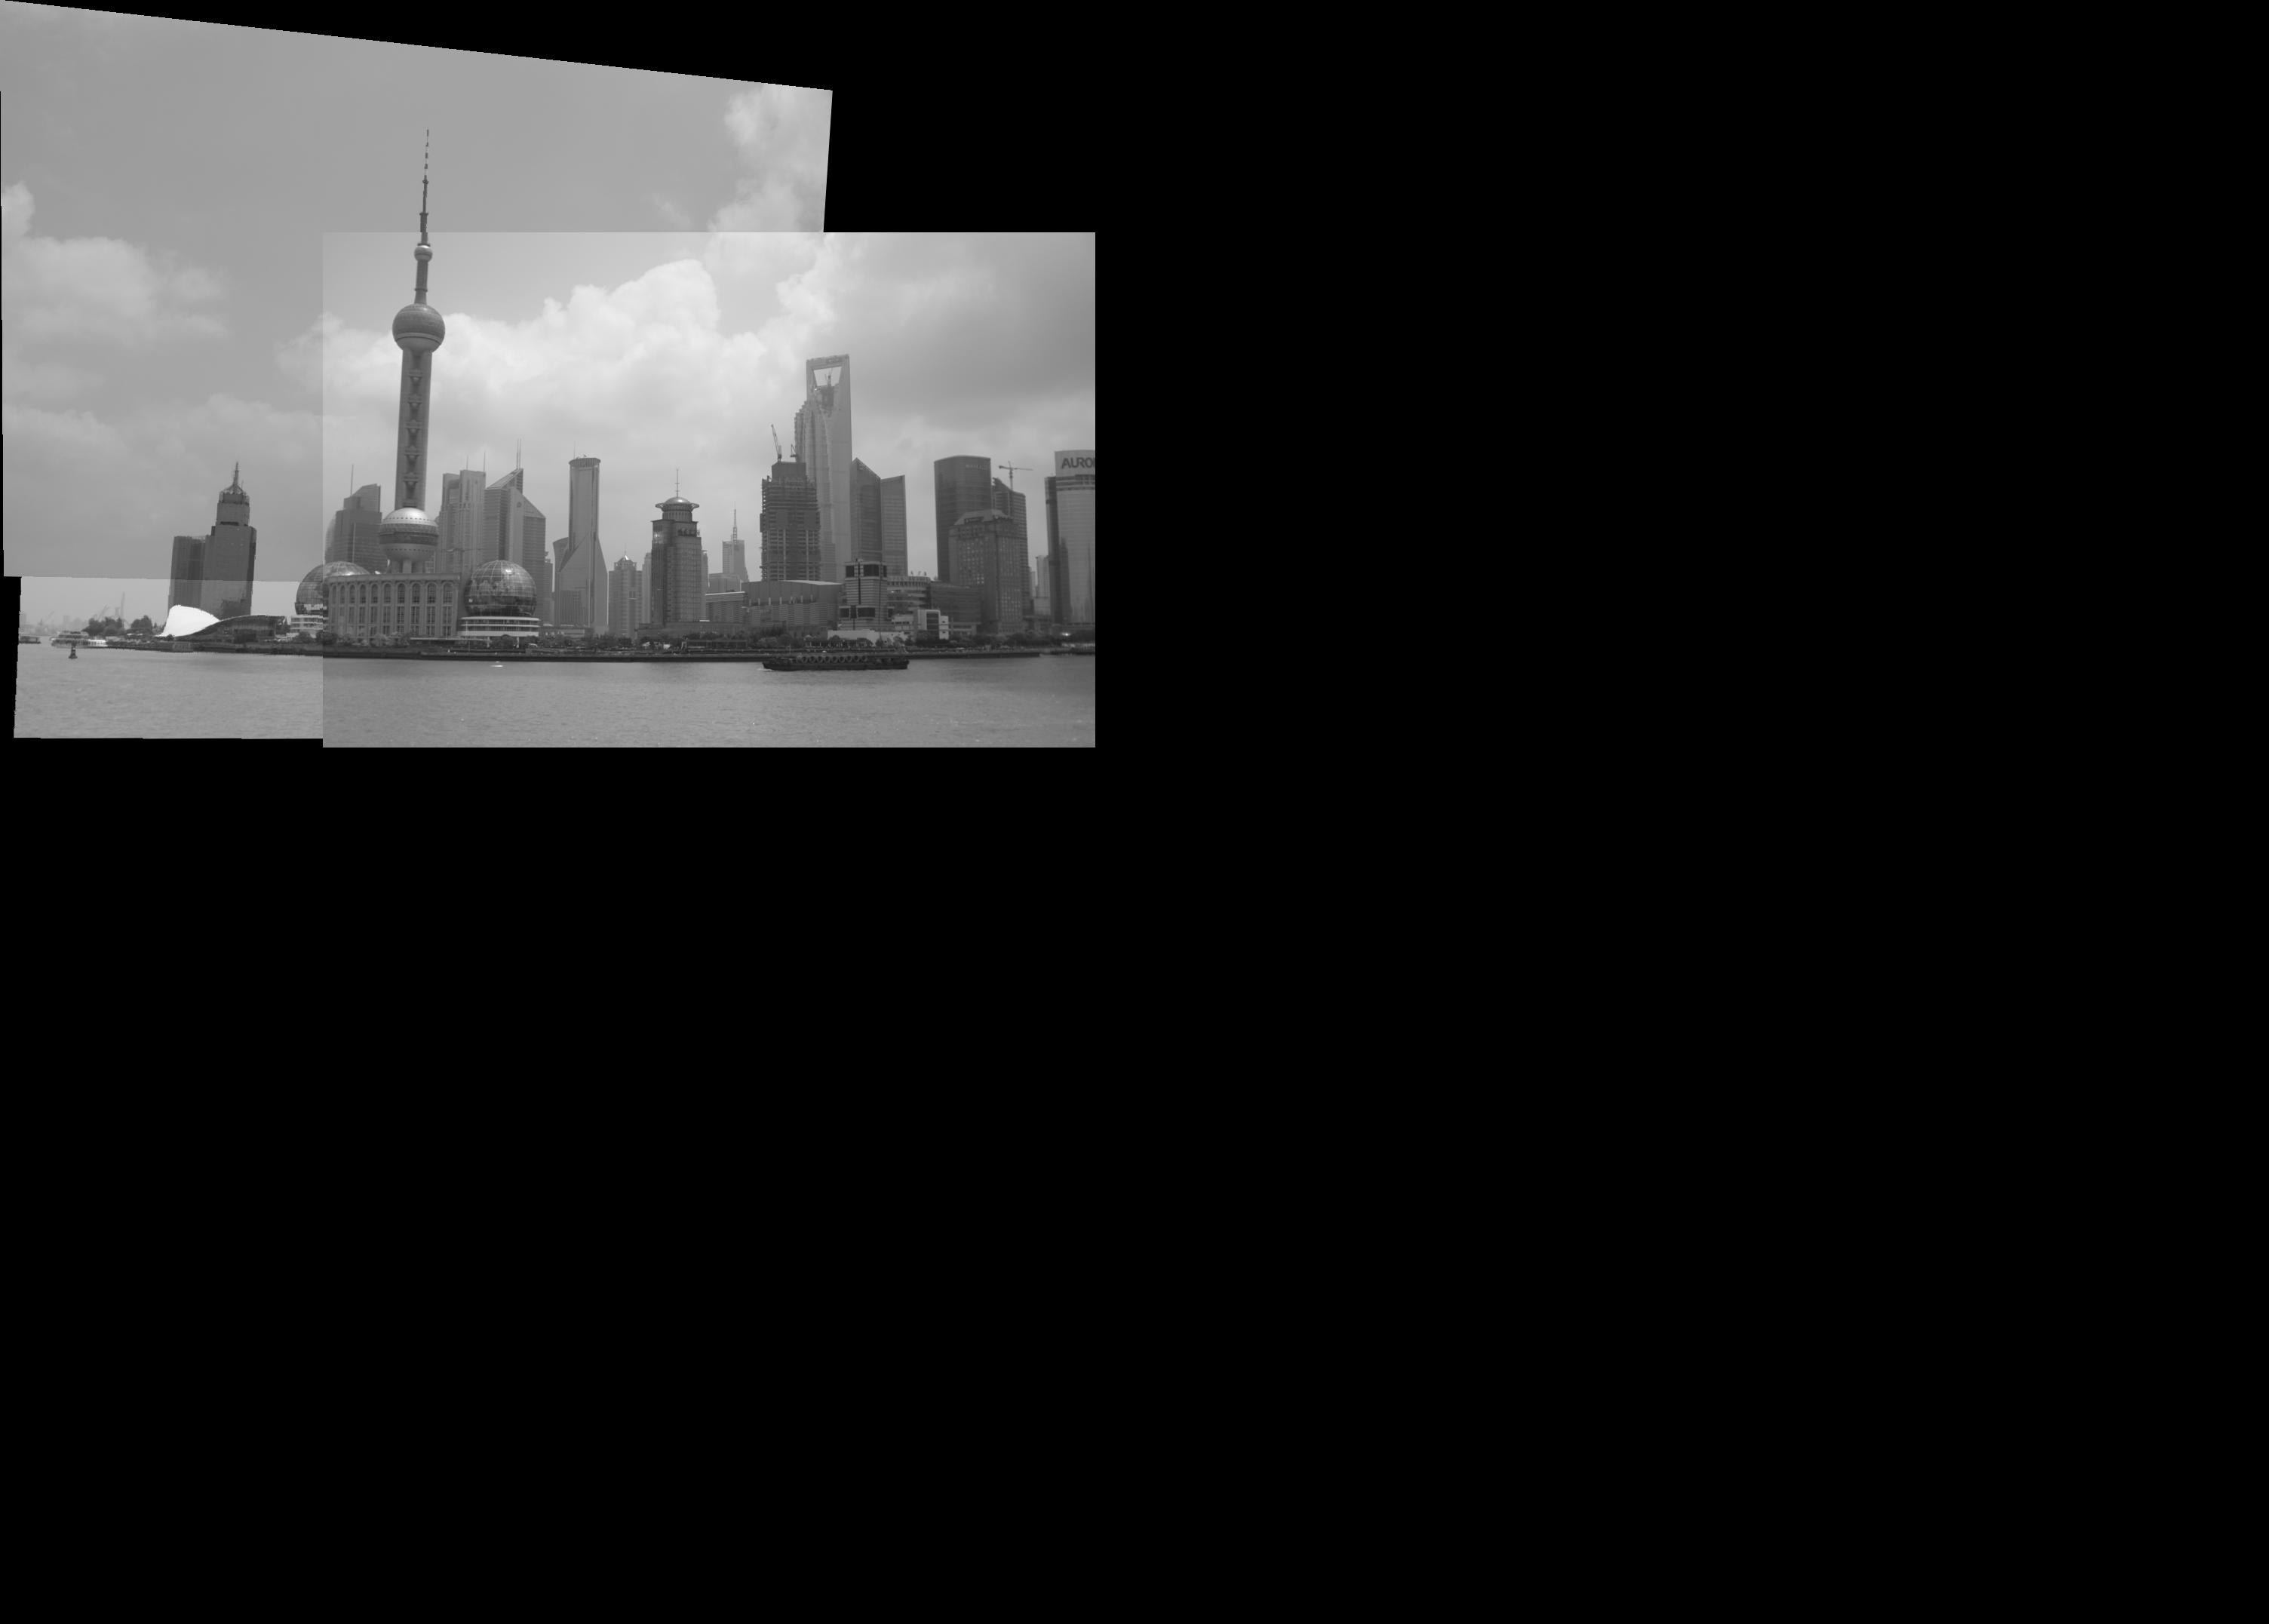

In [ ]:
outputImg_2 = stitchImages(im3, wraped_image, width_shift, height_shift)
cv2_imshow(outputImg_2)

## **trials**

In [ ]:
def warping(xPoints_dash,yPoints_dash,H,image,inverseWarp = 0):
    ## Checking if there is -ve Points then add the minimum -ve value to all co-ordinate points
    ## else do nothing
    h,w = image.shape[:2]
    new_Xpoints_dash = xPoints_dash.copy()
    new_Ypoints_dash = yPoints_dash.copy()
    minX = np.amin(xPoints_dash)
    minY = np.amin(yPoints_dash)
    maxX = np.amax(xPoints_dash)
    maxY = np.amax(yPoints_dash)
    if(minY < 0):
        newH = int(maxY-minY)
        new_Ypoints_dash += -minY
    else:
        minY=0
        newH = h

    if(minX < 0):
        newW = int(maxX-minX)
        new_Xpoints_dash += -minX
    else:
        minX=0
        newW = w
        
    ##shifting points to a new location in a new image
    forwardWarp_image = np.zeros((newH,newW,3), np.uint8)
    i = 0;
    for y_src in range(h):
        for x_src in range(w):
            if (int(new_Ypoints_dash[i]) < newH) and int(new_Xpoints_dash[i]) < newW:
                forwardWarp_image[int(new_Ypoints_dash[i]),int(new_Xpoints_dash[i])] = image[y_src,x_src]
            i+=1
    inverseWarp_image = forwardWarp_image.copy()
    if inverseWarp:
        h,w = forwardWarp_image.shape[:2]
        ## Inverse Warping
        for y in range(h):
            for x in range(w):
                
                point = np.array([[x+minX,y+minY,1]])
                revPoint = np.dot(np.linalg.inv(H),point.T)
                lamd = revPoint[2]
                revPoint = revPoint/lamd
                pointX = revPoint[0][0] 
                pointY = revPoint[1][0]
                if(pointX < 0 or pointY < 0):
                     continue;
                # Bilinear Interpolation
                pointX_ceil = math.ceil(pointX)
                pointX_floor = math.floor(pointX)
                pointY_ceil = math.ceil(pointY)
                pointY_floor = math.floor(pointY)          
                matX = np.array([[pointX_ceil-pointX,pointX-pointX_floor]])
                try:
                    matF = np.array([[image[pointY_floor,pointX_floor], image[pointY_ceil,pointX_floor]],[image[pointY_floor,pointX_ceil],image[pointY_ceil,pointX_ceil]]])
                except:
                    pass
                matY = np.array([[pointY_ceil-pointY,pointY-pointY_floor]])
                div =  matX / ((pointX_ceil-pointX_floor)*(pointY_ceil-pointY_floor))
                ## Getting each channel separately
                b =  np.dot(np.dot(matX,matF)[:,:,0],matY.T)
                g =  np.dot(np.dot(matX,matF)[:,:,1],matY.T)
                r =  np.dot(np.dot(matX,matF)[:,:,2],matY.T)
                rgb_uint8 = (np.dstack((r,g,b))).reshape(-1) ##  stack them
                inverseWarp_image[y,x] = rgb_uint8
    return inverseWarp_image,forwardWarp_image,minX,minY

In [ ]:
def getCorrespondence(image,H):
    #img = cv2.imread("image2.jpg")
    h,w = image.shape[:2]
    xPoints = []
    yPoints = []
    ##Forward Warping
    for y in range(h): ## rows
        for x in range(w): ## columns 
            point = np.array([[x,y,1]])
            newPoint = np.dot(H,point.T)
            lamd = newPoint[2]
            newPoint = newPoint/lamd
            xPoints.append(newPoint[0][0])
            yPoints.append(newPoint[1][0])
    xPoints = np.array(xPoints)
    yPoints = np.array(yPoints)
    return xPoints,yPoints;

In [ ]:
xPoints,yPoints = getCorrespondence(img1,H)

In [ ]:
import math

In [ ]:
xPoints_dash = []
Width,Length,_ = img1.shape
for i in range(Length):
  for j in range(Width):
    p_new = apply_homography(H,[i,j])

    # if p_new[1]<0:
    # new_img[p_new[1],p_new[0]] = img1[j][i]

In [ ]:
inverseWarp_image,forwardWarp_image,minX,minY = warping(xPoints,yPoints,H,img1,inverseWarp = 0)

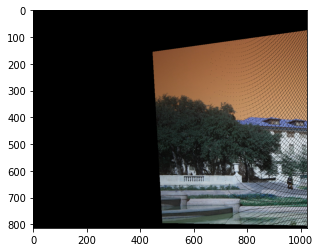

In [ ]:
plt.imshow(forwardWarp_image)

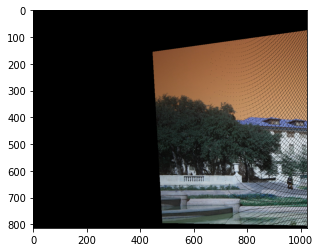

In [ ]:
plt.imshow(inverseWarp_image)

In [ ]:
def limit(point,height):
    if point[1]<0:
        point[1]=0
    if point[1]>height:
        point[1]=height-1
    return point[1]

In [ ]:
def boundary_box (h,N,M):
  '''
  Returns new cordinates of the bounding box
  N --> img.shape[0] -> x -> height (rows)
  M --> img.shape[1] -> x -> width (cols)
  '''
  #Top left
  A= [0,0,1]
  A_new  = np.dot(h,A)
  #Normalize
  A_new = A_new / A_new[2]
  A_new = [round(i) for i in A_new]
  A_new[1] = limit(A_new,img2.shape[0])
  #Bottom left
  B=[0,N-1,1]
  B_new = np.dot(h,B )
  B_new = B_new / B_new[2]
  B_new = [round(i) for i in B_new]
  B_new[1] = limit(B_new,img2.shape[0])
  #Top right
  C=[M-1,0,1]
  C_new = np.dot(h,C )
  C_new = C_new / C_new[2]
  C_new = [round(i) for i in C_new]
  C_new[1] = limit(C_new,img2.shape[0])
  #Bottom right
  D=[M-1,N-1,1]
  D_new = np.dot(h,D )
  D_new = D_new / D_new[2]
  D_new = [round(i) for i in D_new]
  D_new[1] = limit(D_new,img2.shape[0])
  return A_new,B_new,C_new,D_new

In [ ]:
A_new,B_new,C_new,D_new = boundary_box (H,img2.shape[1],img2.shape[0])

In [ ]:
A_new,B_new,C_new,D_new 

([447, 76, 1], [503, 682, 1], [1131, 0, 1], [1223, 682, 1])

# *other*

## **Calculate Homography**

In [ ]:
correspondenceList = []
points_1 = []
points_2 = []
for match in matches:
  (x1, y1) = key_points_1[match.queryIdx].pt
  (x2, y2) = key_points_2[match.trainIdx].pt
  points_1.append([x1,y1])
  points_2.append([x2,y2])
  correspondenceList.append([x1, y1, x2, y2])

NameError: ignored

In [ ]:
def calculateHomography(correspondences):
    #loop through correspondences and create assemble matrix
    A = []
    for corr in correspondences:
        p1 = np.matrix([corr.item(0), corr.item(1), 1])
        p2 = np.matrix([corr.item(2), corr.item(3), 1])

        a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
              p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
        a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
              p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
        A.append(a1)
        A.append(a2)

    A = np.matrix(A)

    #svd composition
    u, s, v = np.linalg.svd(A)

    #reshape the min singular value into a 3 by 3 matrix
    h = np.reshape(v[8], (3, 3))

    #normalize and now we have h
    h = (1/h.item(8)) * h
    return h

In [ ]:
correspondenceList = np.array(correspondenceList)

In [ ]:
H = calculateHomography(correspondenceList)

In [ ]:
print(H)

In [ ]:
x = cv2.findHomography(np.array(points_1),np.array(points_2),cv2.RANSAC)
print(x[0])

In [ ]:
p_varification= np.hstack((points_1,np.ones((len(points_1),1))))
for i in range(len(points_1)):
  ph = H.dot(p_varification[i])
  xdash = ph.item(0)
  ydash = ph.item(1)
  one = ph.item(2)
  print([xdash/one//1 , ydash/one//1],'------>',points_2[i])

## **Get Corner**

In [ ]:
def getValues(img,H):
  coords = dict()
  minX = 0x7fffffff
  minY = 0x7fffffff
  maxX = -1 * 0x7fffffff
  maxY = -1 * 0x7fffffff
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      homgCoords = np.array([(col, row, 1)]).T
      transformedCoords = H.dot(homgCoords)
      transformedCoords = transformedCoords/transformedCoords[2];
      newX, newY = int(transformedCoords[0]),int(transformedCoords[1])
      coords[row,col]=np.array([(newX, newY)])
      minX = min(minX, newX)
      minY = min(minY, newY)
      maxX = max(maxX, newX)
      maxY = max(maxY, newY)
  return minX, minY, maxX,maxY, coords

In [ ]:
def warpingImage(img, H, nChannels=3):
  minX, minY, maxX, maxY, coords = getValues(img,H)
  shiftX = minX * -1
  shiftY = minY * -1
  warpedImage = np.zeros(((maxX - minX) + 2, (maxX - minX) + 2, nChannels, 2))
  returnImage = np.zeros(((maxY - minY) + 2, (maxX - minX) + 2, nChannels))
  for row in range(img.shape[0]):
    for col in range(img.shape[1]):
      newX, newY = coords[row,col][0][0], coords[row,col][0][1]
      newX += shiftX
      newY += shiftY
      subpixels = np.array([(newX,newY),(newX+1,newY),(newX,newY+1),(newX+1,newY+1)])
      for subpixel in subpixels:
            for channel in range(nChannels):
              warpedImage[subpixel[1]][subpixel[0]][channel][0] += 1
              warpedImage[subpixel[1]][subpixel[0]][channel][1] += img[row][col][channel]
  for row in range(warpedImage.shape[0]):
   for col in range(warpedImage.shape[1]):
       for channel in range(nChannels):
        if warpedImage[row][col][channel][0] > 0:
           returnImage[row][col][channel] = warpedImage[row][col][channel][1]//warpedImage[row][col][channel][0]
        
  return shiftX, shiftY, returnImage.astype(np.uint8)

In [ ]:
shiftX, shiftY, transformedImg = warpingImage(img1,H)
cv2_imshow(transformedImg)

In [ ]:
def stitchImages(origImg, transformedImg, shiftX, shiftY, nChannels = 3):
  newImg = np.zeros(((origImg.shape[0] + transformedImg.shape[0]), (origImg.shape[1] + transformedImg.shape[1]), nChannels))
  newImg[0:transformedImg.shape[0],0:transformedImg.shape[1]] = transformedImg
  for row in range(origImg.shape[0]):
    for col in range(origImg.shape[1]):
      newX, newY = col + shiftX , row + shiftY
      newImg[newY][newX] = origImg[row][col]
  # delete black rows & columns
  idx = np.argwhere(np.all(newImg[..., :] == 0, axis=0))
  newImg = np.delete(newImg, idx, axis=1)
  idx = np.argwhere(np.all(newImg[..., :] == 0, axis=1))
  newImg = np.delete(newImg, idx, axis=0)
  # rotate image columns if shift was -ve 
  if shiftX < 0:
    newImg = np.roll(newImg, -1* shiftX, axis=1)
  if shiftY < 0:
    newImg = np.roll(newImg, -1* shiftY, axis=0)
  return newImg.astype(np.uint8)

In [ ]:
outputImg = stitchImages(img2, transformedImg, shiftX, shiftY)
cv2_imshow(outputImg)

## **Build in homography**

In [ ]:
point_1 = np.array(points_1, dtype=np.float32)
point_2 = np.array(points_2, dtype=np.float32)

In [ ]:
h, mask = cv2.findHomography(point_1, point_2, cv2.RANSAC)

In [ ]:
height, width, channel = img2.shape 

In [ ]:
img1_reg = cv2.warpPerspective(img1, h, (height, width))

In [ ]:
cv2_imshow(img1_reg)

## **Panorama image with image stitching**

In [ ]:
image_stitcher = cv2.Stitcher_create()
error, stitched_image = image_stitcher.stitch(img2, img1)
cv2_imshow(stitched_image)

In [ ]:
im1 = cv2.imread('/content/shanghai-21.png')
im2 = cv2.imread('/content/shanghai-22.png')
im3 = cv2.imread('/content/shanghai-23.png')

image_stitcher = cv2.Stitcher_create()
error, stitched_image = image_stitcher.stitch(im1, im3)
error, stitched_im = image_stitcher.stitch(im2, stitched_image)
cv2_imshow(stitched_im)

In [ ]:
plt.imshow(stitched_image)